## Imports

In [ ]:
%pip install pandas scikit-learn tensorflow keras tqdm numpy matplotlib pydot IPython

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

import pydot
from IPython.display import Image

import time
import os

In [7]:
# print available GPUs
print("Num GPUs Available: ", tf.config.experimental.list_physical_devices('GPU'))

Num GPUs Available:  []


## Clean Data

In [8]:
if not os.path.exists("clean_train.csv"):
    import csv

    def to_int(s):
        try:
            return int(s)
        except:
            int_str = ""
            for i in range(len(str(s))):
                if str(s)[i] in "0123456789.":
                    int_str += str(s)[i]
            if int_str == "":
                return 0
            elif int_str.count(".") > 1:
                return int(int_str.replace(".", ""))
            else:
                return int(float(int_str))

    input_file = open("train.csv", "r")

    output_csv_array = []

    for row in csv.reader(input_file):
        
        output_row = []
        
        for i in range(len(row)):
            if row[0] == "PassengerId":
                print("header")
                if i in [0,1,2,4,5,6,7,8,9,11]:
                    output_row.append(row[i])
                
            
            elif i in [0,1,2,5,6,7,9]:
                try:
                    output_row.append(to_int(row[i]))
                except:
                    print("Error: ", row[i])
            
            elif i == 4:
                output_row.append(0 if row[i] == "male" else 1)
            
            elif i == 8:
                output_row.append(to_int(row[i]))
                
            elif i == 11:
                output_row.append(0 if row[i] == "S" else 1 if row[i] == "C" else 2)
        
        output_csv_array.append(output_row)

    with open("clean_train.csv", "w", newline="") as output_file:
        writer = csv.writer(output_file)
        writer.writerows(output_csv_array)

    input_file.close()

else:
    print("clean_train.csv already exists")


clean_train.csv already exists


## import data

In [9]:
df = pd.read_csv("clean_train.csv")


X, y = df.iloc[:, 2:], df.iloc[:, 1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## AI Model

In [10]:
def train_model(X_train, y_train, X_test, y_test, iterations=100, epochs = 100, batch_size=32, model_arg=None):
    if model_arg == None:
        model = Sequential()
        model.add(Dense(16, activation='relu', input_shape=(X_train.shape[1],)))
        model.add(Dense(32, activation="relu"))
        model.add(Dropout(0.5))
        model.add(Dense(64, activation="leaky_relu"))
        model.add(Dropout(0.5))
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.1))
        model.add(Dense(32, activation="softmax"))
        model.add(Dense(8, activation="relu"))
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        print(model.summary())
    else:
        model = model_arg
    accuracy_array = []
    for i in tqdm(range(iterations)):
        model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=0)
        accuracy_array.append(model.evaluate(X_test, y_test, verbose=0)[1])
    return model, accuracy_array

In [11]:
def plot_model_architecture(model):
    """Plot a Keras model's architecture and display it in the notebook."""
    plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
    return Image(filename='model.png')

## Plot Model accuracy

In [13]:
def plot_accuracy(accuracy_array):
    plt.plot(accuracy_array)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    
    #add a trendline
    plt.plot(np.poly1d(np.polyfit(range(len(accuracy_array)), accuracy_array, 1))(range(len(accuracy_array))))
    print("poly1d:", np.poly1d(np.polyfit(range(len(accuracy_array)), accuracy_array, 1)))
    
    #set the y axis to start at 0 and end at 1
    plt.ylim(0, 1)
    
    plt.show()

## User Input

In [15]:
iterations = 20
epochs = 50
batch_size = 16

## Load Model

In [16]:
if os.path.exists("model.h5"):
    model = load_model("model.h5")
    print("model loaded")
else:
    model = None
    print("model not loaded")

model not loaded


## Run Model

In [17]:
t1 = time.time()


model, accuracy_array = train_model(X_train, y_train, X_test, y_test, iterations=iterations, epochs=epochs, batch_size=batch_size, model_arg = model)

_, accuracy = model.evaluate(X_test, y_test)

print("time:", str(int((time.time() - t1)*1000)) + "ms")

print("Accuracy: ", accuracy)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                144       
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 512)               33280     
                                                                 
 dropout_2 (Dropout)         (None, 512)               0

  0%|          | 0/20 [00:00<?, ?it/s]C:\Users\Linus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]
  5%|▌         | 1/20 [00:21<06:40, 21.09s/it]C:\Users\Linus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[

KeyboardInterrupt: 

## Print Results

time: 716350ms
Accuracy:  0.638059675693512
[]
poly1d:  
1.058e-18 x + 0.6381


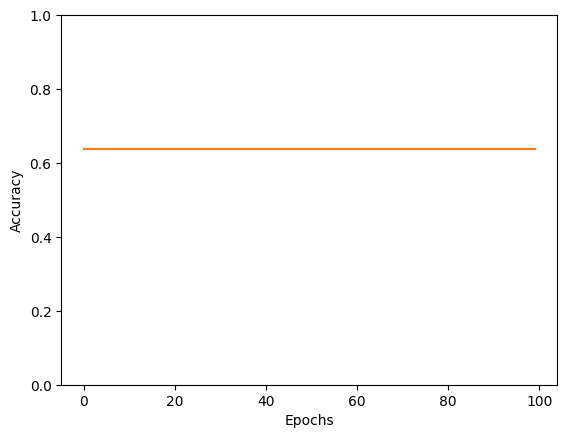

iterations: 100 epochs: 50 batch_size: 32
total: 5000


In [28]:
print("time:", str(int((time.time() - t1)*1000)) + "ms")

print("Accuracy: ", accuracy)

accuracy_anomalys = [i for i in accuracy_array if i < accuracy * 0.8]

print(accuracy_anomalys)

plot_accuracy(accuracy_array)

print("iterations:", iterations, "epochs:", epochs, "batch_size:", batch_size)

print("total:", iterations * epochs)

## visualize Model architecture

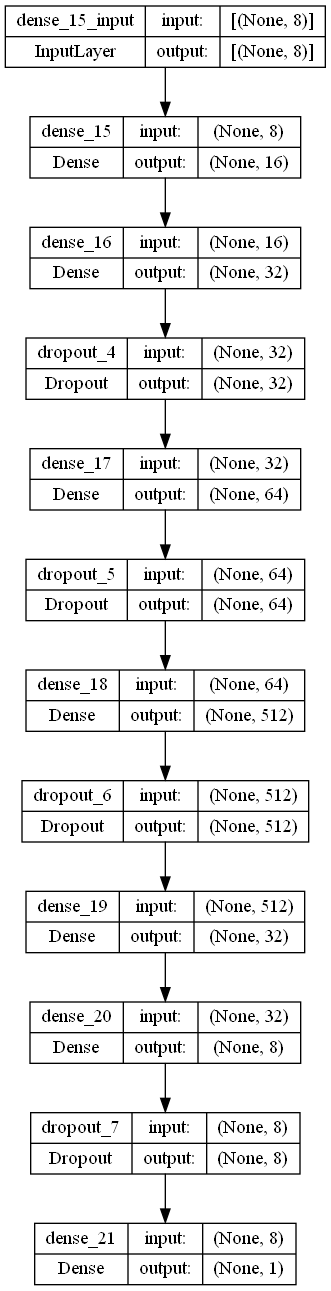

In [29]:
plot_model_architecture(model)